In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing libraries:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import zipfile

In [3]:
# Open files:

zf = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Assignment/Fake_News.zip')
fake_df = pd.read_csv(zf.open('Fake.csv'))
true_df = pd.read_csv(zf.open('True.csv'))

# Data exploration


In [ ]:
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


Both dataset have no non-null.

## Combining the datasets fake and true articles, and creating label columns 'fake' and 'true'.

In [ ]:
# Verify column names
fake_df_cols = fake_df.columns
true_df_cols = true_df.columns

# Iterate through list of column names to ensure they match
for (j,k) in enumerate(zip(fake_df_cols, true_df_cols)):
    # Print
    print(j,k)

0 ('title', 'title')
1 ('text', 'text')
2 ('subject', 'subject')
3 ('date', 'date')


In [4]:
# Adding the target column - Fake = '0' and True = '1', as class:
fake_df['class'] = '0'
true_df['class'] = '1'

## Observe from word cloud the most common word from fake and true news

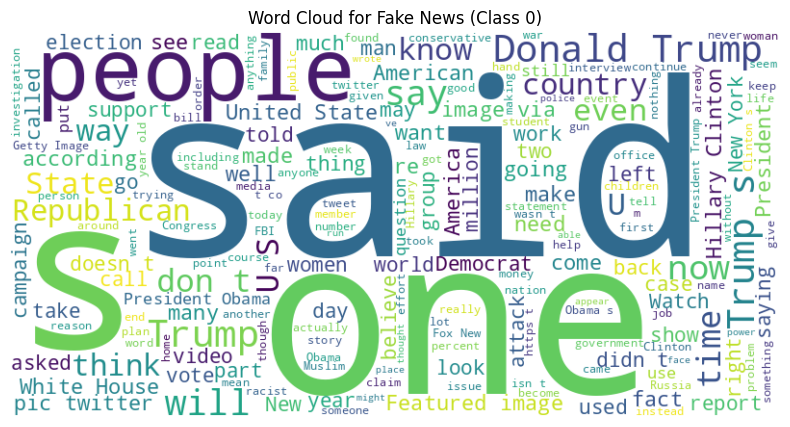

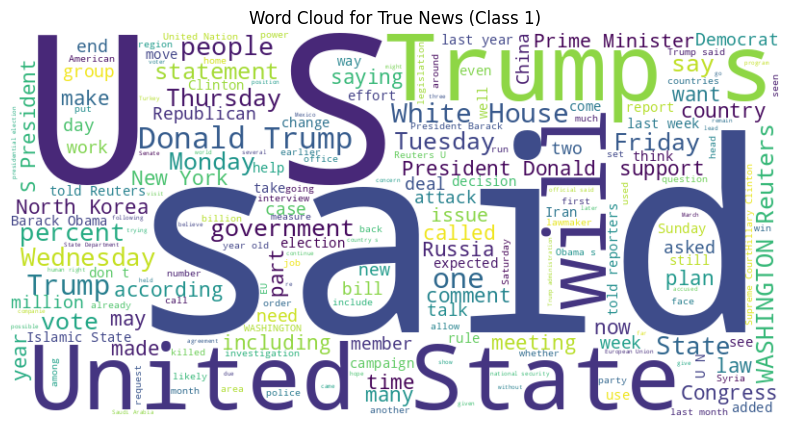

In [ ]:
from wordcloud import WordCloud

# Function to generate and display word clouds
def generate_word_cloud(data_frame, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data_frame['text']))

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Generate and display word clouds for both classes
generate_word_cloud(fake_df, "Word Cloud for Fake News (Class 0)")
generate_word_cloud(true_df, "Word Cloud for True News (Class 1)")

### The word "said" is the most frequently occurring word in both datasets. In the fake news dataset, "said" is frequently followed by words such as "one," "people," and "Donald Trump." Conversely, in the true news dataset, "said" is often followed by terms like "United States," "U," "S," and "Trump."

In [5]:
# Combine the data sets
df = pd.concat([fake_df, true_df])

# View
print(f'Combined: {df.shape} | Fake: {fake_df.shape} | True: {true_df.shape}')

Combined: (44898, 5) | Fake: (23481, 5) | True: (21417, 5)


In [ ]:
df.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Data Cleaning

In [6]:
# Dropping unrelevant columns 'date', 'title' and 'subject':
df.drop(['date', 'subject', 'title'], axis=1, inplace=True)

In [ ]:
df.describe(include='all')

,text,class
count,44898,44898
unique,38646,2
top,,0
freq,627,23481


###There is 38646 unique values from 44898 records, which indicates that there is duplicates. Lets remove the duplicates.

In [7]:
# Removing duplicates values

df.drop_duplicates(subset=None, keep='first', inplace=True)
df.reset_index(inplace=True, drop=True)

df.describe(include='all')

,text,class
count,38647,38647
unique,38646,2
top,,1
freq,2,21192


In [ ]:
df.head()

,text,class
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


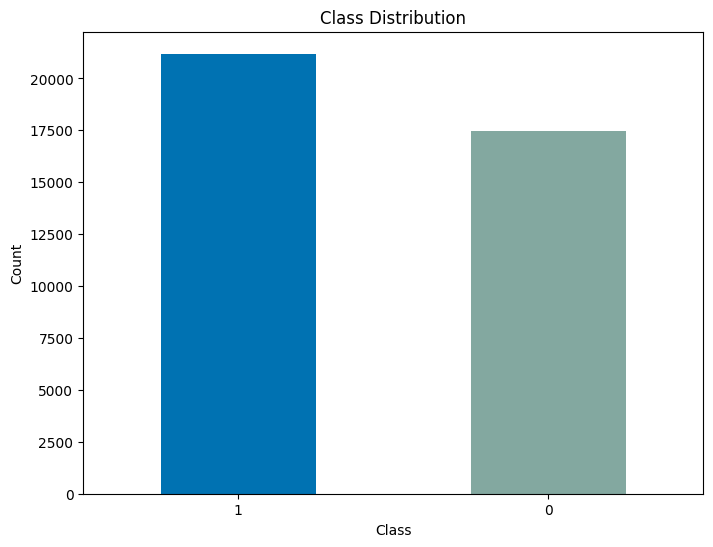

1: 54.83%
0: 45.17%


In [ ]:
# Class distribution:
plt.figure(figsize=(8, 6))
class_distribution = df['class'].value_counts()
class_distribution.plot(kind='bar', color=['#0072B2', '#83A8A0'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0, label=['Fake', 'True'])
plt.show()

# Print the class distribution as percentages
total_samples = len(df)
for label, count in class_distribution.items():
    percentage = (count / total_samples) * 100
    print(f'{label}: {percentage:.2f}%')

### The difference in distribution between the classes is less than 10%, which falls below the threshold for model application.

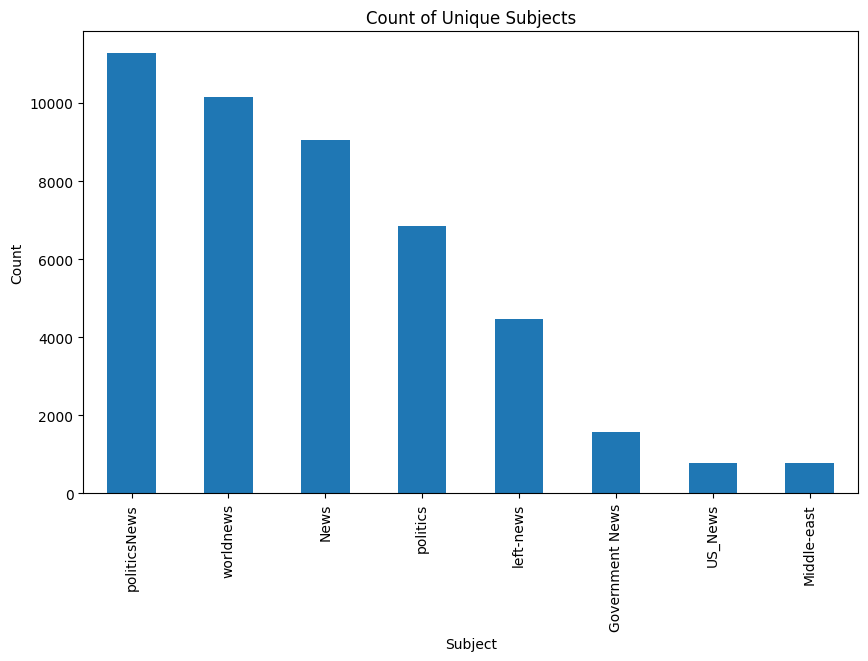

In [ ]:
# Check the data objects in the 'subject' column and count:
subject_counts = df['subject'].value_counts()

# Create a bar plot to visualize the counts
plt.figure(figsize=(10, 6))
subject_counts.plot(kind='bar')
plt.title('Count of Unique Subjects')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

### The top three subjects with the highest frequency are "politicsNews," followed by "worldnews," and "News."

#Text Preprocessing - using stop words, spacy lemmatization and tokenaizing.

In [8]:
!pip install stop-words
!pip install contractions
from stop_words import get_stop_words
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import contractions
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Combine the stopword lists
stop_words = list(get_stop_words('en'))
nltk_words = list(stopwords.words('english'))
stop_words.extend(nltk_words)

# Load the spaCy English language model
nlp = spacy.load('en_core_web_sm')

# Function for text cleaning and lemmatization
def preprocess(text):
    # Expand contractions
    text = contractions.fix(text)
    # Making all words lowercase
    text = text.lower()
    # Removing URL using regular expression
    text = re.sub(r'http\S+', '', text)
    # Removing all characters other than letters, numbers, and spaces
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [w for w in tokens if w.lower() not in stop_words]
    # Lemmatization using spaCy
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]
    return " ".join(tokens)

# Apply the preprocess function to the 'text' column
df['processed_txt'] = df['text'].apply(preprocess)

# Check the first few rows of the DataFrame
print(df[['text', 'processed_txt']].head())

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32896 sha256=62cb85a0b5661ef234d020b31af090913b3cf5194438e13b32f0e9e38fee6f98
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.1 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milwauk...   
3  On Christmas day, Donald Trump announced that ...   
4  Pope Francis used his annual Christmas Day mes...   

                                       processed_txt  
0  donald trump wish americans happy new year lea...  
1  house intelligence committee chairman devin nu...  
2  friday reveal former milwaukee sheriff david c...  
3  christmas day donald trump announce back work ...  
4  pope francis use annual christmas day message ...  


In [9]:
df.head()

,text,class,processed_txt
0,Donald Trump just couldn t wish all Americans ...,0,donald trump wish americans happy new year lea...
1,House Intelligence Committee Chairman Devin Nu...,0,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",0,friday reveal former milwaukee sheriff david c...
3,"On Christmas day, Donald Trump announced that ...",0,christmas day donald trump announce back work ...
4,Pope Francis used his annual Christmas Day mes...,0,pope francis use annual christmas day message ...


In [10]:
def get_corpus(processed_txt):
    words = []
    for i in processed_txt:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.processed_txt)
corpus[:50]



['donald',
 'trump',
 'wish',
 'americans',
 'happy',
 'new',
 'year',
 'leave',
 'instead',
 'give',
 'shout',
 'enemy',
 'hater',
 'dishonest',
 'fake',
 'news',
 'medium',
 'former',
 'reality',
 'show',
 'star',
 'one',
 'job',
 'country',
 'rapidly',
 'grow',
 'strong',
 'smart',
 'want',
 'wish',
 'friend',
 'supporter',
 'enemy',
 'hater',
 'even',
 'dishonest',
 'fake',
 'news',
 'medium',
 'happy',
 'healthy',
 'new',
 'year',
 'president',
 'angry',
 'pant',
 'tweet',
 '2018',
 'great',
 'year']

In [11]:
from collections import Counter

counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'say': 152142,
 'trump': 110245,
 'president': 46208,
 'yous': 43539,
 'people': 35895,
 'state': 35247,
 'make': 32567,
 'one': 31107,
 'year': 29328,
 'also': 27005}

### From corpus the top 3 words with highest frequency is "say", "trump", and "president".

# Separate dataset into features (X) and targets (y)

In [12]:
from sklearn.model_selection import train_test_split

# stratified 80/20 train/test split of the dataset:
X = df['processed_txt'].values
y = df['class'].values



# Vectorizerization

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X)
freq_term_matrix = count_vectorizer.transform(X)

tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)
print(tf_idf_matrix)

  (0, 212019)	0.06924990657911885
  (0, 211711)	0.2183972160956369
  (0, 211669)	0.07416269737951059
  (0, 210746)	0.028358635657620902
  (0, 209842)	0.016730038038271222
  (0, 209755)	0.024212299048932344
  (0, 209613)	0.03218623815180781
  (0, 209043)	0.16480589567232212
  (0, 207252)	0.07703649577162763
  (0, 207242)	0.05436539170298122
  (0, 207015)	0.07703649577162763
  (0, 204744)	0.032485035182329085
  (0, 203784)	0.018716092048271644
  (0, 200877)	0.033183993743739024
  (0, 196756)	0.09941030924687183
  (0, 195222)	0.07216586133168977
  (0, 190078)	0.01713755460894305
  (0, 188834)	0.07703649577162763
  (0, 188548)	0.05580376718711039
  (0, 187823)	0.024516627230780016
  (0, 187370)	0.04273050917867477
  (0, 186192)	0.019564273322424865
  (0, 186148)	0.07416269737951059
  (0, 186147)	0.07416269737951059
  (0, 185039)	0.06186843672858162
  :	:
  (38646, 49698)	0.09168438295809797
  (38646, 48959)	0.09561237107299028
  (38646, 47973)	0.04286409589390146
  (38646, 47721)	0.2635652

# Modeling

In [14]:
from sklearn.model_selection import train_test_split

# Splitting the data into test data and train data 80/20

X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, y, test_size=0.2, stratify=y, random_state=42)

# Multinomial Naive Bayes (NB)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

NB = MultinomialNB(alpha = 2.0)
NB.fit(X_train, y_train)
Accuracy = NB.score(X_test, y_test)

# Training accuracy
train_accuracy = accuracy_score(y_train, NB.predict(X_train))
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test accuracy
test_accuracy = accuracy_score(y_test, NB.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
classification_rep = classification_report(y_test, NB.predict(X_test))
print("Classification Report:\n", classification_rep)


Training Accuracy: 0.9159
Test Accuracy: 0.9041
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88      3491
           1       0.86      0.99      0.92      4239

    accuracy                           0.90      7730
   macro avg       0.92      0.90      0.90      7730
weighted avg       0.91      0.90      0.90      7730



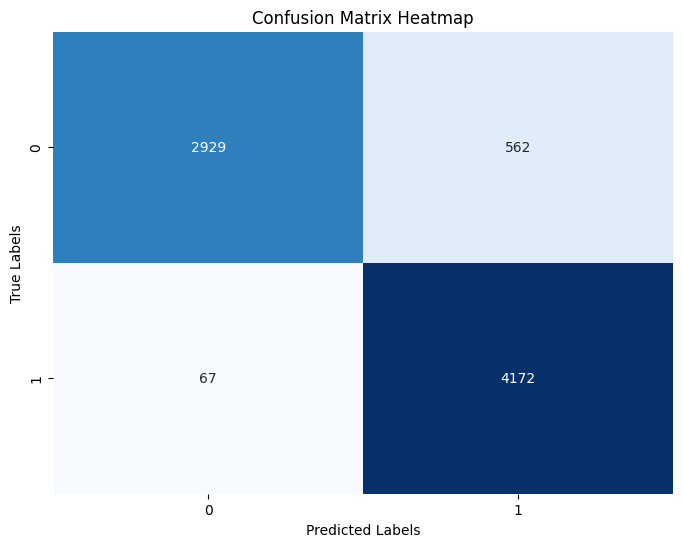

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Default - alpha = 1.0
# Assuming you have trained your classifier and made predictions
y_pred = NB.predict(X_test)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


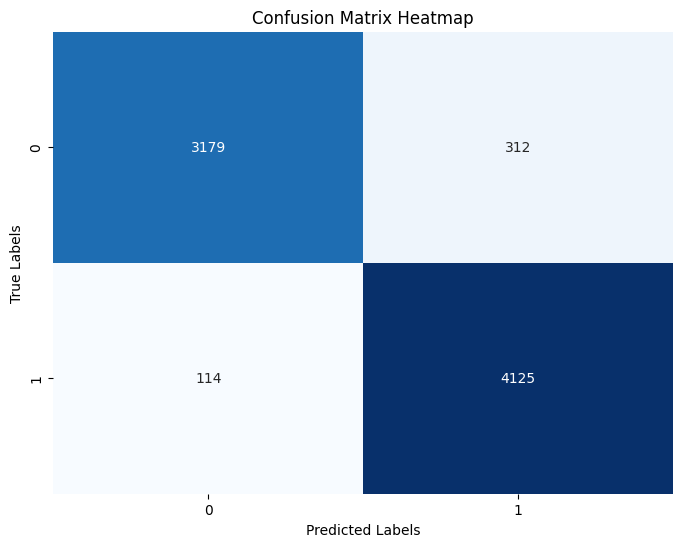

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Default - alpha = 0.1
# Assuming you have trained your classifier and made predictions
y_pred = NB.predict(X_test)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


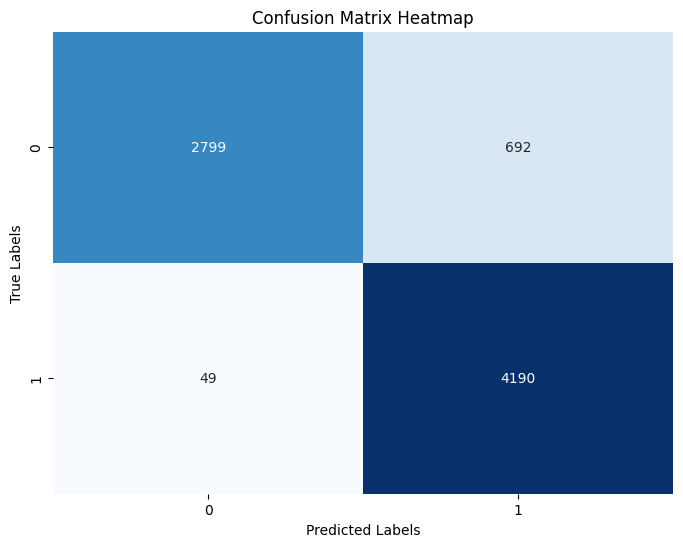

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Default - alpha = 2.0
# Assuming you have trained your classifier and made predictions
y_pred = NB.predict(X_test)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


####################################################################################################################################################

# Neural Network (MLP)

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create and train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), alpha = 0.1, max_iter=100)

history = mlp_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = mlp_model.predict(X_train)

# Make predictions on the test set
y_test_pred = mlp_model.predict(X_test)

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate and print the accuracy, precision, recall, and F1-score on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training Accuracy: 0.9999676553352524
Test Accuracy: 0.9908150064683053
Accuracy: 0.9908
Precision: 0.9908
Recall: 0.9908
F1-score: 0.9908


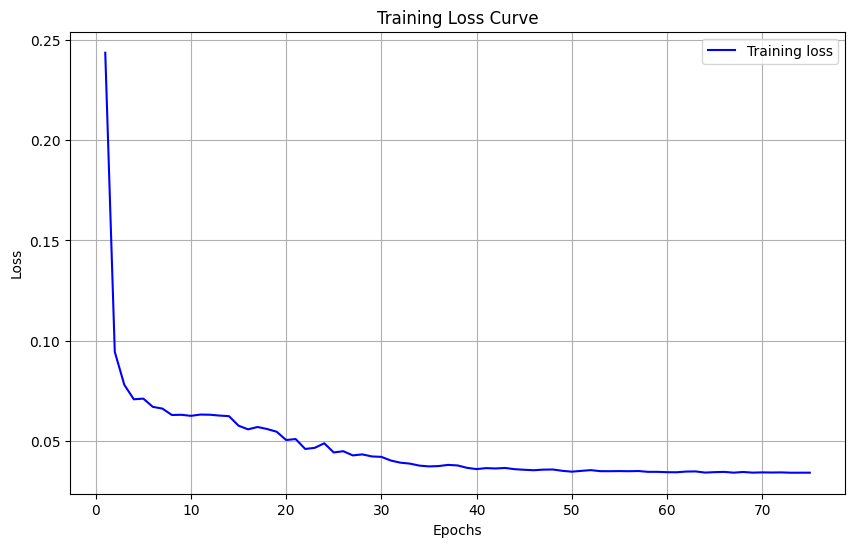

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#  MLPClassifier(hidden_layer_sizes=(100, 100), alpha = 0.1, max_iter=300)

# Extract the loss values
train_loss = history.loss_curve_
num_epochs = len(train_loss)

# Create a range of epochs for the x-axis
epochs = range(1, num_epochs + 1)

# Plot the loss curve for all epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.show()

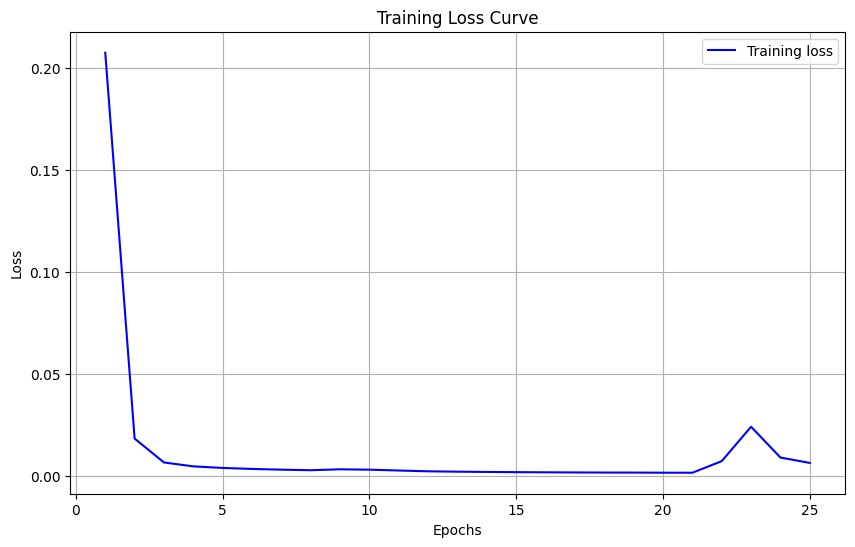

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# MLPClassifier(hidden_layer_sizes=(100, 50), alpha = 0.001, max_iter=200)

# Extract the loss values
train_loss = history.loss_curve_
num_epochs = len(train_loss)

# Create a range of epochs for the x-axis
epochs = range(1, num_epochs + 1)

# Plot the loss curve for all epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.show()

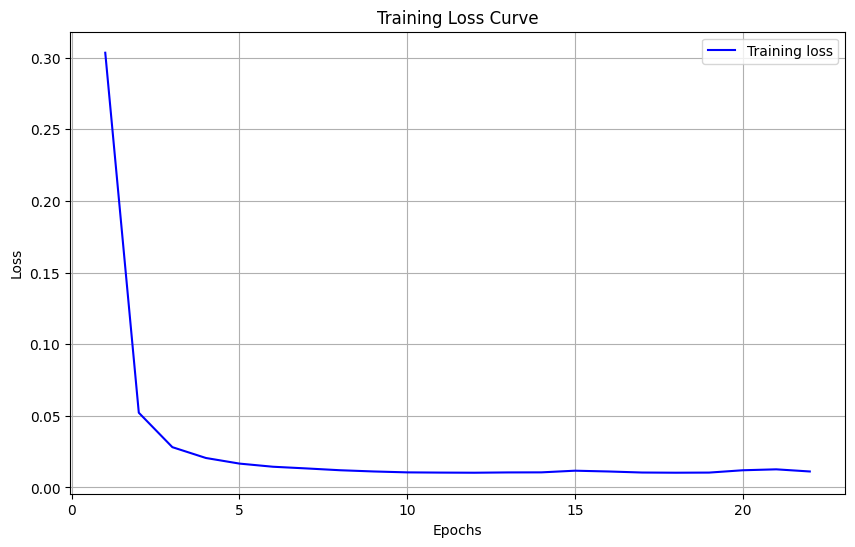

In [ ]:
# MLPClassifier(hidden_layer_sizes=(50, 20), alpha = 0.01, max_iter=100)

# Extract the loss values
train_loss = history.loss_curve_
num_epochs = len(train_loss)

# Create a range of epochs for the x-axis
epochs = range(1, num_epochs + 1)

# Plot the loss curve for all epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.show()

# Model Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Create an SVM model
svm_model = SVC(kernel='sigmoid', C=1.0, random_state=42)

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Make predictions on the test data
y_pred = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Generate a classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", class_report)

Training Accuracy: 0.9967331888604974
Test Accuracy: 0.9921086675291074

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3491
           1       0.99      1.00      0.99      4239

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730



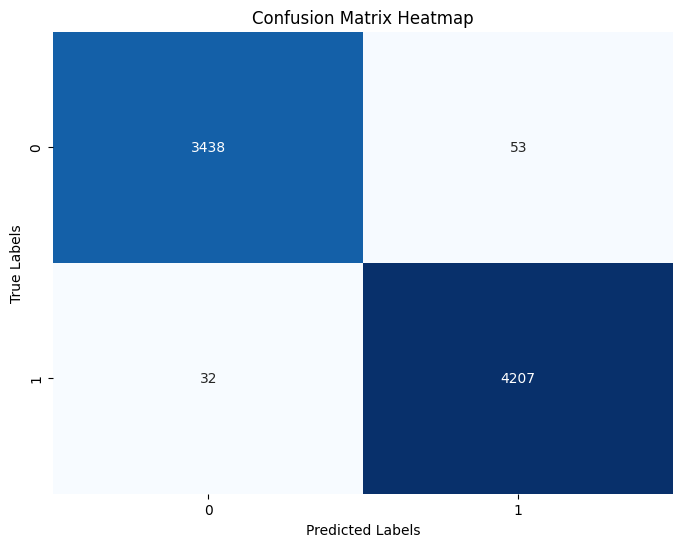

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

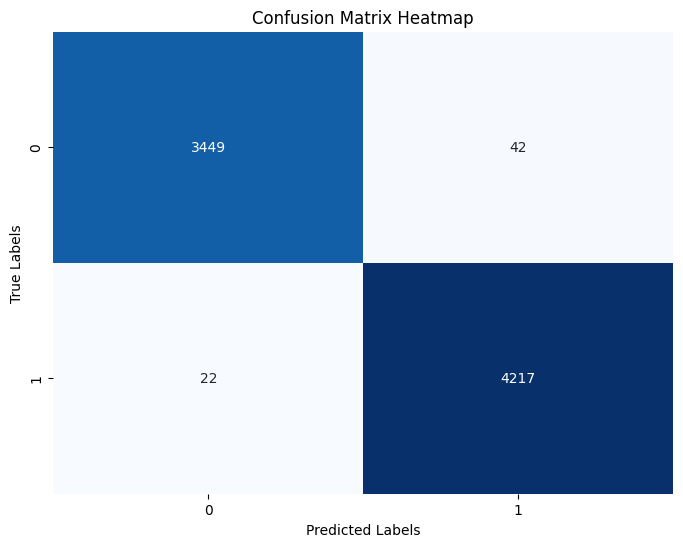

In [ ]:
# svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

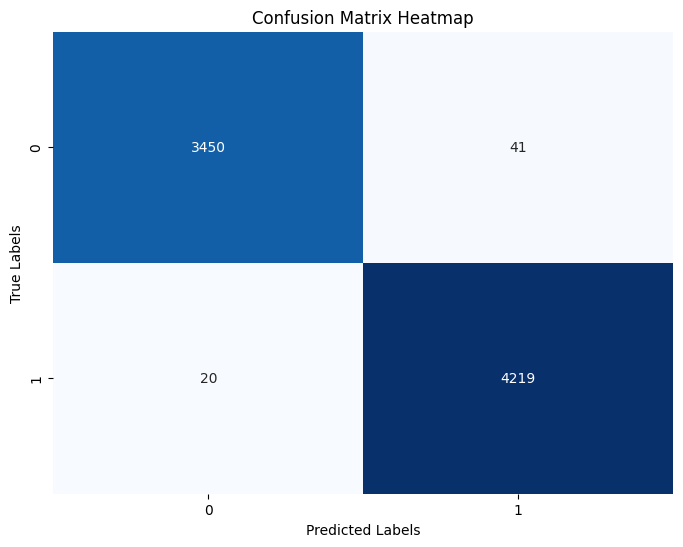

In [ ]:
# svm_model = SVC(kernel='sigmoid', C=1.0, random_state=42)
# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

###########################################################################################################################

# Embedded and Padding

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df['text'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create a label encoder
label_encoder = LabelEncoder()

# Encode the string labels to numeric values
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Create a label encoder
label_encoder = LabelEncoder()

print(y_train_encoded)
print(y_test_encoded)


[1 1 1 ... 0 0 1]
[0 0 0 ... 1 1 0]


In [ ]:
#! pip install keras-Preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

max_words = 800
max_sequence_length = 100

# Tokenization and sequence padding
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')


In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix('/content/drive/MyDrive/Colab Notebooks/Lab11/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

# Checking the coverage
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / max_words)

89.8675


# MNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

NB = MultinomialNB(alpha = 2.0)
NB.fit(X_train, y_train)
Accuracy = NB.score(X_test, y_test)

# Training accuracy
train_accuracy = accuracy_score(y_train, NB.predict(X_train))
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test accuracy
test_accuracy = accuracy_score(y_test, NB.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
classification_rep = classification_report(y_test, NB.predict(X_test))
print("Classification Report:\n", classification_rep)

Training Accuracy: 0.5708
Test Accuracy: 0.5583
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.54      0.53      3491
           1       0.60      0.57      0.59      4239

    accuracy                           0.56      7730
   macro avg       0.56      0.56      0.56      7730
weighted avg       0.56      0.56      0.56      7730



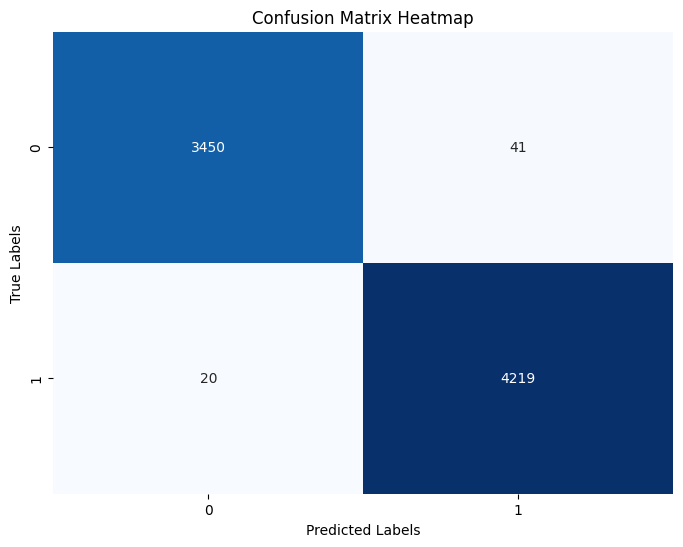

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# MultinomialNB(alpha = 1.0)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

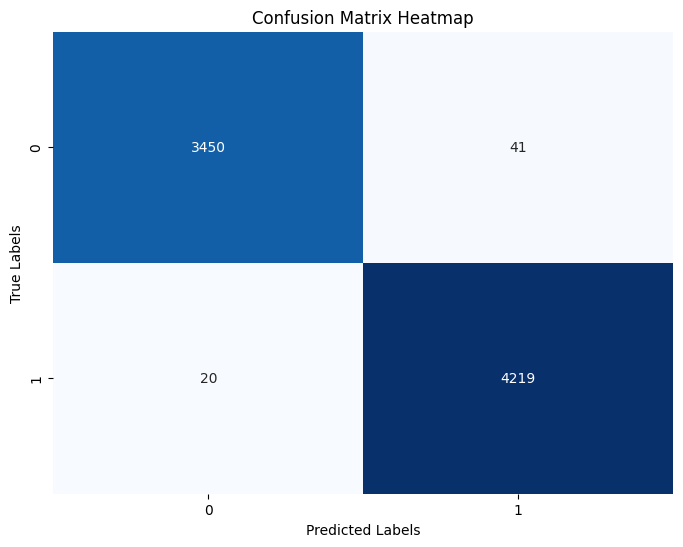

In [ ]:

# MultinomialNB(alpha = 0.1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Create and train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100), alpha = 0.1, max_iter=300)

history = mlp_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = mlp_model.predict(X_train)

# Make predictions on the test set
y_test_pred = mlp_model.predict(X_test)

# Calculate and print the training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate and print the accuracy, precision, recall, and F1-score on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Training Accuracy: 0.9297473881683216
Test Accuracy: 0.5467011642949547
Accuracy: 0.5467
Precision: 0.5471
Recall: 0.5467
F1-score: 0.5469


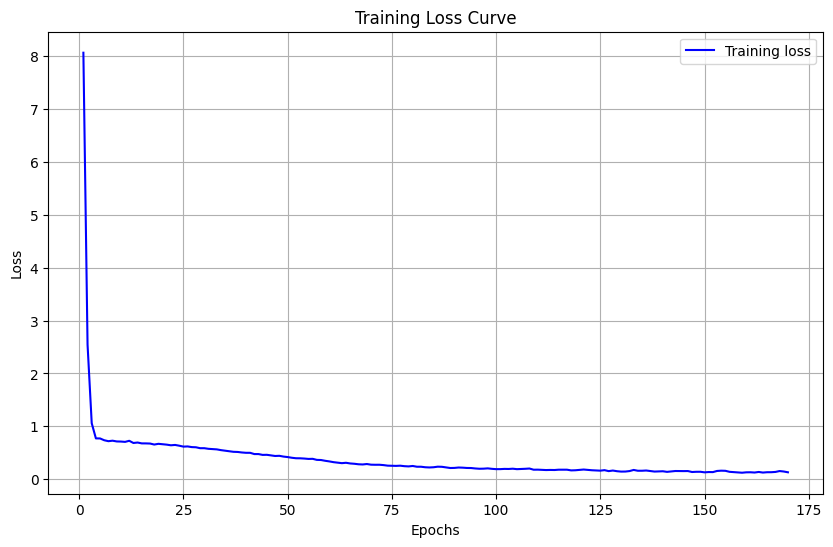

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#  MLPClassifier(hidden_layer_sizes=(100, 50), alpha = 0.001, max_iter=200)

# Extract the loss values
train_loss = history.loss_curve_
num_epochs = len(train_loss)

# Create a range of epochs for the x-axis
epochs = range(1, num_epochs + 1)

# Plot the loss curve for all epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

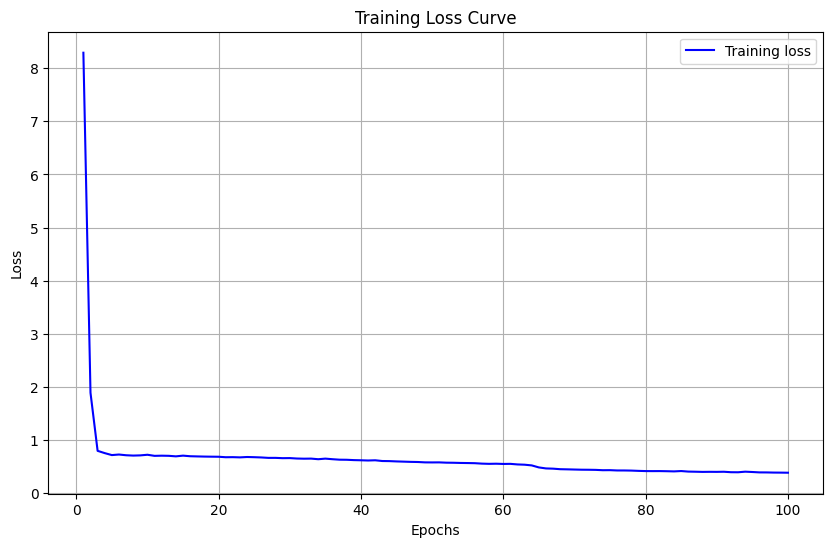

In [ ]:
# MLPClassifier(hidden_layer_sizes=(50, 20), alpha = 0.01, max_iter=100)

# Extract the loss values
train_loss = history.loss_curve_
num_epochs = len(train_loss)

# Create a range of epochs for the x-axis
epochs = range(1, num_epochs + 1)

# Plot the loss curve for all epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

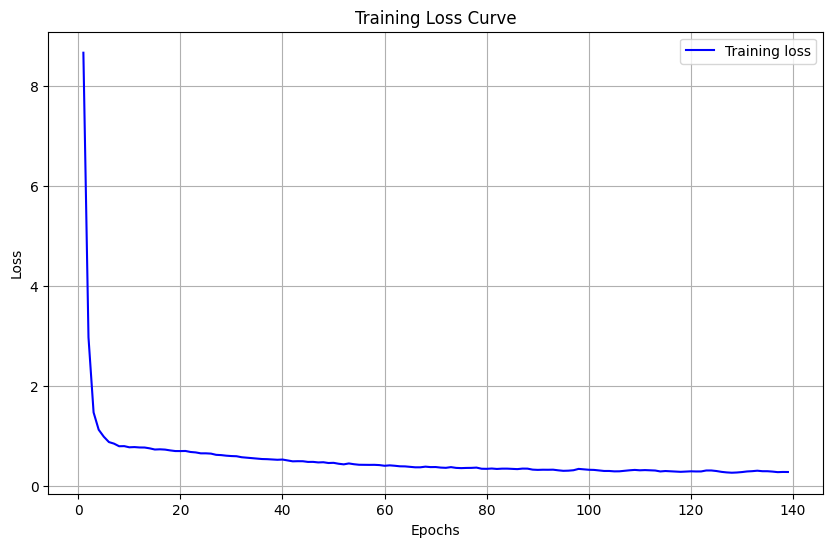

In [ ]:
# MLPClassifier(hidden_layer_sizes=(100, 100), alpha = 0.1, max_iter=300)

# Extract the loss values
train_loss = history.loss_curve_
num_epochs = len(train_loss)

# Create a range of epochs for the x-axis
epochs = range(1, num_epochs + 1)

# Plot the loss curve for all epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##################################################################################################################

#SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create an SVM model
svm_model = SVC(kernel='sigmoid', C=1.0, random_state=42)

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Make predictions on the test data
y_pred = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Generate a classification report
class_report = classification_report(y_test, y_pred)

# Print the results
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", class_report)

Training Accuracy: 0.46058802600511045
Test Accuracy: 0.5059508408796896

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.41      0.43      3491
           1       0.55      0.58      0.56      4239

    accuracy                           0.51      7730
   macro avg       0.50      0.50      0.50      7730
weighted avg       0.50      0.51      0.50      7730



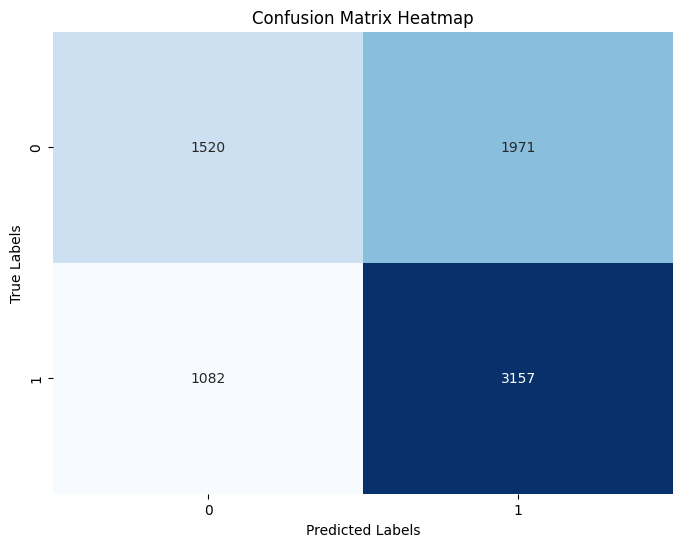

In [ ]:
# SVC(kernel='rbf', C=1.0, random_state=42)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

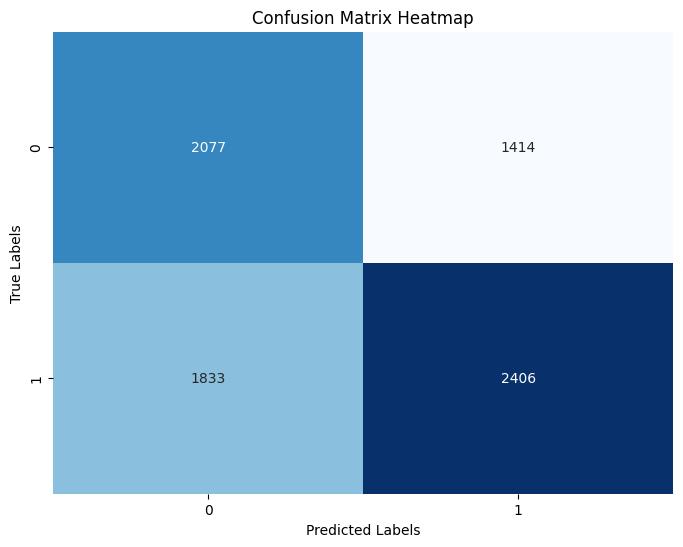

In [ ]:
# SVC(kernel='poly', C=1.0, random_state=42)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

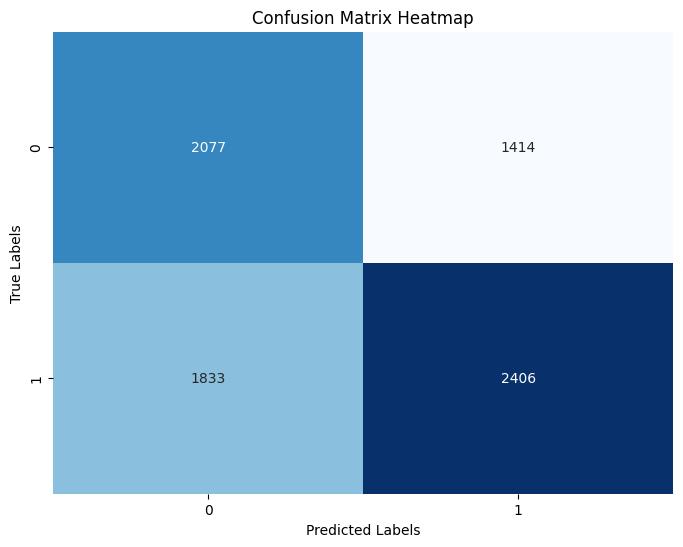

In [ ]:
# SVC(kernel='sigmoid', C=1.0, random_state=42)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()